In [1]:
import numpy as np
import tensorflow as tf
from keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
import matplotlib.pylab as plt

In [2]:
!pip install -U tensorflow_datasets


  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=fe201dc03c7e95d2a1dfebcb40afd36ea2b8230e3f2ad371b69dc64853902976
  Stored in directory: c:\users\giovanni\appdata\local\pip\cache\wheels\e1\e8\83\ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
""" Cargamos el dataset cats_vs_dogs de Tensorflow Datasets: """

(train_dataset, val_dataset), dataset_info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'), #Este split es 80% de entrenamiento y 20% validación (fuente: https://www.tensorflow.org/datasets/splits)
    with_info = True,
    as_supervised = True
)

In [ ]:
# Información del dataset cats vs dogs:
dataset_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='~/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and

In [ ]:
# Esta función nos permite pre-procesar las muestras, tenemos que re-escalarlas y normalizarlas antes de pasarlas al modelo
# Utilizaremos como medida 64 x 64 para que no tome tanto tiempo de entrenamiento
def preprocesar_imagen(imagen, etiqueta, res=(64,64)):
  imagen = tf.image.resize(imagen, (res[0], res[1]))/255.0
  return imagen, etiqueta

In [ ]:
cant_muestras = dataset_info.splits['train'].num_examples

batchsize = 32
ancho, alto = (64,64)

DataTrain = train_dataset.cache().batch(batchsize).prefetch(1)
DataVal= val_dataset.batch(batchsize).prefetch(1)

DataTrain = train_dataset.cache().map(preprocesar_imagen).batch(batchsize).prefetch(1)
DataVal = val_dataset.map(preprocesar_imagen).batch(batchsize).prefetch(1)

In [ ]:
""" Arquitectura de la red convolucional: """

# Capa de entrada de ancho x alto x 3:
Entrada = Input(shape=(ancho, alto, 3))

# Primera capa de convolución con 32 filtros con un kernel de tamaño (3x3) 
x = Conv2D(filters=32, kernel_size=3, activation="relu")(Entrada)
# Hacemos una capa de Max Pooling de 2x2 para agrupar las características de la convolución anterior
x = MaxPooling2D(pool_size=2)(x)

# Segunda capa de convolución con 64 filtros con un kernel de tamaño (3x3) 
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
# Hacemos una capa de Max Pooling de 2x2 para agrupar las características de la convolución anterior
x = MaxPooling2D(pool_size=2)(x)

# Tercera capa de convolución con 128 filtros con un kernel de tamaño (3x3)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
# Hacemos una capa de Max Pooling de 2x2 para agrupar las características de la convolución anterior
x = MaxPooling2D(pool_size=2)(x)

# Una última capa de convolución con 256 filtros con kernel de 3x3 
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)

# Ponemos una capa de Dropout para que apague el 50% de las neuronas aleatoriamente para mejorar el performance
x = Dropout(0.5)(x)

# Aplanamos todo a un sólo vector 1D
x = Flatten()(x)

# Este vector lo pasamos a una FFN (Feed Forward Network) para que aprenda de las características encontradas
ffn = Dense(32, activation='relu')(x)
ffn = Dense(128, activation='relu')(ffn)
ffn = Dense(128, activation='relu')(ffn)
ffn = Dense(32, activation='relu')(ffn)
ffn = Dropout(0.5)(ffn)

# Ahora una capa de salida con 1 neurona con activación sigmoide, que determinará si la muestra es clase 'gato' o 'perro'
Salida = Dense(1, activation="sigmoid")(ffn)

Modelo = Model(inputs=Entrada, outputs=Salida)

# Compilamos el modelo con los hyperparámetros: 
# Optimizador Adam con una tasa de aprendizaje de 1x10-4
# Función de pérdida: Binary Crossentropy (para que prediga si es una clase o la otra)
# Metricas de 'exactitud' para evaluar luego el modelo

Modelo.compile(optimizer = Adam(learning_rate=1e-4), loss = losses.BinaryCrossentropy(), metrics=['accuracy'])

Modelo.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 128)       7385

In [ ]:
history = Modelo.fit(DataTrain,
                    epochs = 15,
                    batch_size=1,
                    steps_per_epoch=None,
                    validation_data = DataVal)

Epoch 1/15
582/582 [==============================] - 11s 17ms/step - loss: 0.6850 - accuracy: 0.5444 - val_loss: 0.6606 - val_accuracy: 0.6307
Epoch 2/15
582/582 [==============================] - 10s 18ms/step - loss: 0.6104 - accuracy: 0.6727 - val_loss: 0.5567 - val_accuracy: 0.7240
Epoch 3/15
582/582 [==============================] - 9s 16ms/step - loss: 0.5449 - accuracy: 0.7362 - val_loss: 0.5080 - val_accuracy: 0.7620
Epoch 4/15
582/582 [==============================] - 9s 15ms/step - loss: 0.5074 - accuracy: 0.7622 - val_loss: 0.4704 - val_accuracy: 0.7857
Epoch 5/15
582/582 [==============================] - 9s 15ms/step - loss: 0.4624 - accuracy: 0.7898 - val_loss: 0.4515 - val_accuracy: 0.7915
Epoch 6/15
582/582 [==============================] - 9s 16ms/step - loss: 0.4354 - accuracy: 0.8093 - val_loss: 0.4304 - val_accuracy: 0.8093
Epoch 7/15
582/582 [==============================] - 9s 16ms/step - loss: 0.4045 - accuracy: 0.8256 - val_loss: 0.4134 - val_accuracy: 0.80

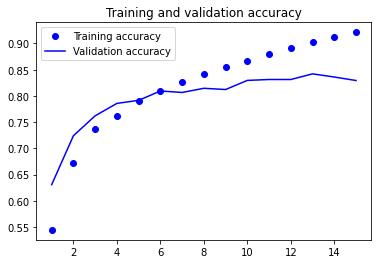

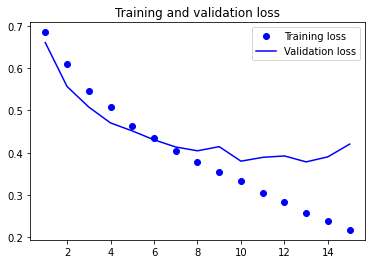

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# Para extraer los nombres de las clases, usamos la info obtenida del Tensorflow datasets que cargamos
clases = dataset_info.features['label'].names
clases

['cat', 'dog']

In [ ]:
# Cargamos un lote de 32 imágenes (batch_size) para comprobar, convertimos DataTrain a Iterator y usamos next() para obtenerlo
# y así sea el siguiente lote cuado terminó el entrenamiento (es decir, es un lote de muestras que no se usó para entrenar el modelo)
imagenes_prueba, labels_prueba = next(iter(DataTrain.take(1)))
imagenes_prueba = imagenes_prueba.numpy()
labels_prueba = labels_prueba.numpy()

predicciones = Modelo.predict(imagenes_prueba)


In [ ]:
# Para saber a que clase pertenece, tomamos las predicciones (que son float entre 0 y 1), que representan la probabilidad de 
# que la muestra sea la clase 0 o la clase 1 (0 = 'cat' y 1 = 'dog', según la info del TF dataset).
# Para utilizarlo como índice de la lista clases, lo redondeamos a int, así solo será 1 si es suficientemente alta la probabilidad, y 0 si es baja.
predicciones_ids = []
predicciones_nombre = []
for lbl in predicciones:
  predicciones_ids.append(round(lbl[0]))
  predicciones_nombre.append(clases[round(lbl[0])])

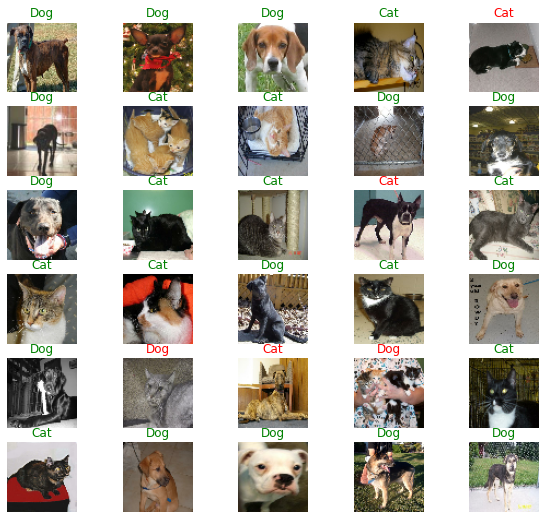

In [ ]:
# Graficando las predicciones:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(imagenes_prueba[n])
  
  if (predicciones_ids[n] == labels_prueba[n]):
      color = "green" 
  else:
    color = "red"

  plt.title(predicciones_nombre[n].title(), color=color)
  plt.axis('off')

In [ ]:
# Cargando una imagen de internet para probar
from PIL import Image
import requests
from io import BytesIO

urls = ['https://i.ytimg.com/vi/wbf-jBF8YuU/hqdefault.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/d/d7/Jindo-dog1.jpg',
        'https://estaticos.muyinteresante.es/uploads/images/article/624b35795bafe8b021ef7862/3-si-encuentro-gatito-abandonado-1140x855.jpg',
        'https://laopinion.com/wp-content/uploads/sites/3/2016/07/perro1.jpg',
        'https://cope-cdnmed.agilecontent.com/resources/jpg/3/0/1606143755203.jpg'
       ]
Img = []
for url in urls:
  response = requests.get(url)
  imagen = Image.open(BytesIO(response.content))
  # Reescalamos al tamaño que necesitamos para el input del modelo (128 x 128)
  imagen = imagen.resize((ancho, alto))
  Img.append(imagen)


In [ ]:
# Pre-procesado: 
for i in range(len(Img)):
  # Normalizar los valores de los pixeles:
  Img[i] = np.array(Img[i]) / 255

Img = np.array(Img)
Img.shape

(5, 64, 64, 3)

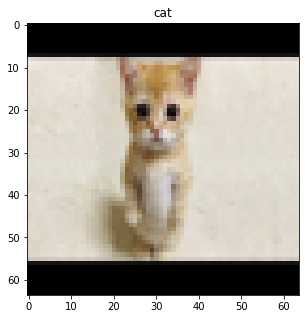

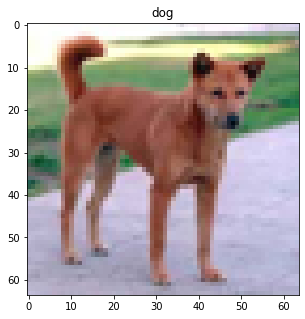

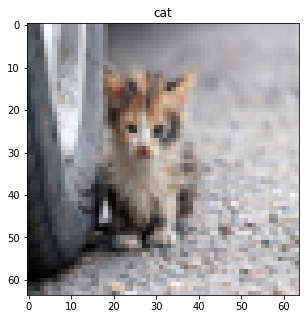

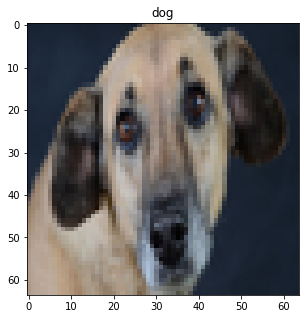

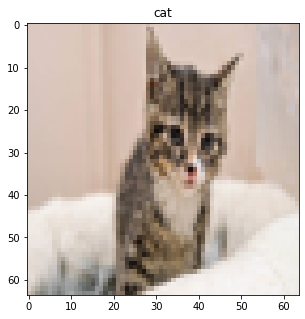

In [ ]:
pred_web = Modelo.predict(Img)

for i in range(len(Img)):
    img = Img[i]
    plt.figure(figsize=(5,5))
    lbl = clases[round(pred_web[i][0])]
    plt.title(lbl)
    plt.imshow(Img[i])
    plt.show()